In [4]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import soundfile as sf
import torch
import yaml
from torch.utils.data import Dataset
import torchaudio

from tqdm import tqdm

import sys
sys.path.append("../")
import seq2seq_vc.models
from seq2seq_vc.utils import read_hdf5, write_hdf5
from seq2seq_vc.utils.plot import plot_attention, plot_generated_and_ref_2d, plot_1d
from seq2seq_vc.utils.types import str2bool
from seq2seq_vc.utils.duration_calculator import DurationCalculator

import sys
sys.path.append("../")
from pyfiles.dataset import Parallelo2oVCMelDataset
from pyfiles.utils import Dict2Obj
from pyfiles.feature_extractor import get_vocos

sys.path.append("../../cuhksz-phd/sho_util/pyfiles/")
from pytorch import cuda2numpy, cuda2cpu
from basic import plot_spectrogram
from sound import play_audio

import numpy as np
import joblib
import glob
datasplit = list(np.load("./data_split_ARCTIC.npy", allow_pickle=True))

In [5]:
# Dataset Variables
dataset_dir = "/mntcephfs/lab_data/shoinoue/Dataset/L2-ARCTIC/"
speakers = ["HKK", "TNI"]
src_spk = "HKK"
trg_spk = "TNI"

scaler_filename = f"ckpts/scalers/HKK_TNI.save"
scaler = joblib.load(scaler_filename)

In [7]:
args = {}
args["rank"] = 0
args["checkpoint"] = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts/HKK_TNI/checkpoint-50000steps.pkl"
args["outdir"] = "./ckpts/outputs/HKK_INI/"
args["config_path"] = "./../egs/arctic/vc1/conf/vtn.v1.melmel.yaml"
args["init_checkpoint"] = ""
args["resume"] = ""
args["distributed"] = False
args = Dict2Obj(args)

# load main config
with open(args.config_path) as f:
    config = yaml.load(f, Loader=yaml.Loader)
config.update(vars(args))

# Customization
config["model_params"]["idim"] = 100
config["model_params"]["odim"] = 100

In [ ]:
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
torch.cuda.set_device(args.rank)
    
### Dataset Preparation ###
dataset = Parallelo2oVCMelDataset(dataset_dir, speakers, src_spk, trg_spk, datasplit, scaler, "test")

### Model Preparation ###
model_class = getattr(seq2seq_vc.models, config["model_type"])
model = model_class(**config["model_params"])
model.load_state_dict(torch.load(args.checkpoint, map_location="cpu")["model"])
model = model.eval().to(device)
    
### Vocoder Preparation ###
data_dir = "/mntcephfs/lab_data/shoinoue/"
fs = 24000
# fs = 16000

if fs==24000:
    config_path = f"{data_dir}Models/trained_models/vocos/24k/config.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/24k/pytorch_model.bin"
elif fs==16000:
    config_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/config16k.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/vocos16k_noncausal_last.ckpt"
vocoder = get_vocos(config_path, model_path, fs)

In [16]:
import time
import os

In [19]:
with torch.no_grad(), tqdm(dataset, desc="[decode]") as pbar:
    for idx, batch in enumerate(pbar, 1):
        start_time = time.time()
        utt_id = batch["utt_id"]
        x = batch["src_feat"]
        x = torch.tensor(x, dtype=torch.float).to(device)
        outs, probs, att_ws = model.inference(
            x, config["inference"], spemb=None
        )

        # plot figures
        plot_generated_and_ref_2d(
            outs.cpu().numpy(),
            config["outdir"] + f"/outs/{utt_id}.png",
            origin="lower",
        )
        
        plot_1d(
            probs.cpu().numpy(),
            config["outdir"] + f"/probs/{utt_id}_prob.png",
        )
        plot_attention(
            att_ws.cpu().numpy(),
            config["outdir"] + f"/att_ws/{utt_id}_att_ws.png",
        )
        
        ### Waveform ###
        if not os.path.exists(os.path.join(config["outdir"], "wav")):
            os.makedirs(os.path.join(config["outdir"], "wav"), exist_ok=True)
        denormalized_mel = scaler.inverse_transform(cuda2numpy(outs))
        y = vocoder.decode(torch.tensor(denormalized_mel.T).unsqueeze(0))
        sf.write(
            os.path.join(config["outdir"], "wav", f"{utt_id}.wav"),
            y.cpu().numpy()[0],
            fs,
            "PCM_16",
        )
        
        ### Mel ###
        if not os.path.exists(os.path.join(config["outdir"], "mel")):
            os.makedirs(os.path.join(config["outdir"], "mel"), exist_ok=True)
            
        np.save(os.path.join(config["outdir"], "mel", f"{utt_id}.npy"), denormalized_mel)
        if idx>2:
            break

[decode]:   2%|▏         | 2/100 [00:14<11:47,  7.22s/it]


# Check the result

source


ground truth


predicted


<AxesSubplot: >

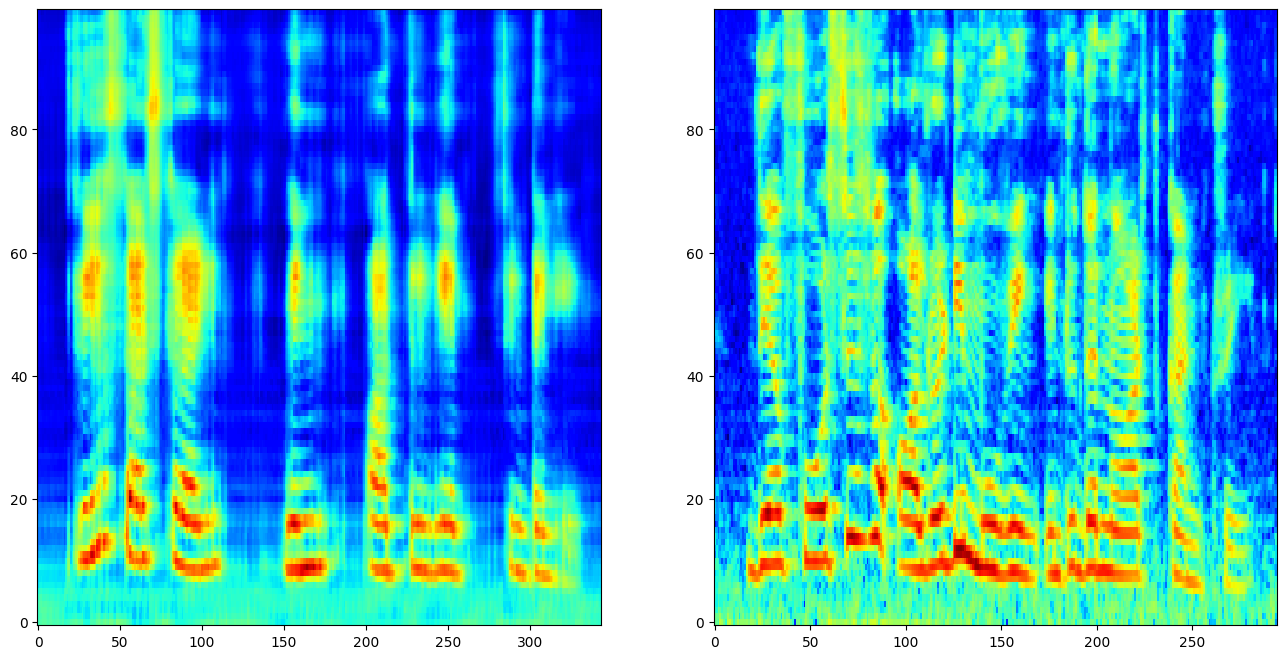

In [22]:
utt_id = dataset.files[1]
data = dataset[dataset.files.index(utt_id)]

melpath = os.path.join(config["outdir"], "mel", f"{utt_id}.npy")
wavpath = os.path.join(config["outdir"], "wav", f"{utt_id}.wav")
predmel = np.load(melpath)
predwav, sr = torchaudio.load(wavpath)
gtmel = data["trg_feat"]
gtmel = scaler.inverse_transform(gtmel)
gtwav = vocoder.decode(torch.tensor(gtmel.T).unsqueeze(0))
sourcemel = data["src_feat"]
sourcemel = scaler.inverse_transform(sourcemel)
sourcewav = vocoder.decode(torch.tensor(sourcemel.T).unsqueeze(0))

%matplotlib inline  
fig = plt.figure(figsize=(16, 8))
print("source")
play_audio(sourcewav, fs)
print("ground truth")
play_audio(gtwav, fs)
print("predicted")
play_audio(predwav, sr)
plot_spectrogram(predmel.T, fig, (1,2,1))
plot_spectrogram(gtmel.T, fig, (1,2,2))